In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
%matplotlib inline

In [ ]:
# checking the number of images for each class.
data_directory = '/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train2/'
#data_directory = '/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train/'

num_images = []
for root, dirs, files in os.walk(data_directory):
  if files == []:
    continue
  else:
    num_images.append(len(files))
print(num_images)
# to test the size of the images
image_size_test = ImageFolder(data_directory, T.ToTensor())
len(image_size_test)
#checking the size of the first 10 images in the dataset

im_count = 0
for image,_ in image_size_test:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break
height = []
width = []
for image,_ in image_size_test:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

## Course Project for zero-to-gans 

This notebook uses the [Stanford Dogs dataset  Classification](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset).

I used this medium article [How to fetch kaggle datasets into google colab](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) to download the kaggle dataset into my google drive. Beware fellow datascience practitioners of these thingsissues while working on this dataset-
1) Massive image datasets (numbering into several GB)
2) Download times 
3) there is no separate training/val/test folders but only labelled folders

In [4]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

In [5]:
!ls

kaggle.json  pima-indians-diabetes.csv	stanford_dogs_dataset


In [ ]:
#import opendatasets as od
#od.download('https://www.kaggle.com/c/jovian-pytorch-z2g')
#import zipfile
#with zipfile.ZipFile('./jovian-pytorch-z2g/jovian-pytorch-z2g.zip', 'r') as zip_ref:
#    zip_ref.extractall('./jovian-pytorch-z2g')
#!unzip \*.zip && rm *.zip

In [ ]:
#data_dir = '/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/images_annotations/'
data_dir = '/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train/'
print(len(os.listdir(data_dir)),os.listdir(data_dir))
#classes = os.listdir(data_dir + "/train")
#print(classes)

The next cell was previously run to ensure all folder names were lowercase and only underscores (by replacing - or empty space).

In [ ]:
#import os
#%cd /content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/images_annotations/
#for cls in classes_dir:
#  new_cls=cls.replace("-","_")
#  new_cls=new_cls.lower()
#  print(cls,new_cls)
#  os.rename(cls,new_cls)

In [ ]:
# # Creating Train / Val / Test folders (One time use)
import os
import numpy as np
import shutil
import random
root_dir = '/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/' # data root path
classes_dir = os.listdir(data_dir) #total labels

val_ratio = 0.15
test_ratio = 0.05
#os.makedirs(root_dir +'train/' )
#os.makedirs(root_dir +'val/' )
#os.makedirs(root_dir +'test/' )
for cls in classes_dir:
    os.makedirs(root_dir +'train2/' + cls )
    os.makedirs(root_dir +'val2/' + cls)
    os.makedirs(root_dir +'test2/' + cls)
# Creating partitions of the data after shuffeling
    src = data_dir + cls # Folder to copy images from
    allFileNames = os.listdir(src) 
    print(allFileNames)
    #imagefilenames= allFileNames.endswith('.jpg')
    imagefilenames = [i for i in allFileNames if i.endswith('.jpg')]

    np.random.shuffle(imagefilenames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(imagefilenames),
                                                          [int(len(imagefilenames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(imagefilenames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(imagefilenames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

# Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train2/' + cls)
        #shutil.copy(name, root_dir +'train/')

    for name in val_FileNames:
        shutil.copy(name, root_dir +'val2/' + cls)
        #shutil.copy(name, root_dir +'val/')

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test2/' + cls)
        #shutil.copy(name, root_dir +'test/')

In [6]:
def cls(image_file):
    image_file2 = image_file.split('_')
    #pd.find(classes_dir,image_file2[:-1])
    return '_'.join(image_file2[:-1])

In [7]:
#myimgs=os.listdir('/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train2/')
#myimgs=os.listdir('/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/val/')
#print(cls(myimgs[400]))

In [35]:
from PIL import Image
def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
#def parse_breed(fname):
#    parts = fname.split('_')
#    return '_'.join(parts[:-1])

In [9]:
img_size = 150
#imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = T.Compose([T.Resize((img_size,img_size)),
                        #T.CenterCrop(img_size, padding=1, padding_mode='reflect'), 
                       #  T.RandomHorizontalFlip(),
                        #T.RandomRotation(degrees=15),
                         T.ToTensor()
                         #T.Normalize(*imagenet_stats,inplace=True)
                         ])
val_tfms=T.Compose([T.Resize((img_size,img_size)),
#[T.RandomCrop(32, padding=1, padding_mode='reflect'), 
                    #     T.RandomHorizontalFlip(),
                     #   T.RandomRotation(degrees=15),
                         T.ToTensor()
                      #   T.Normalize(*imagenet_stats,inplace=True)]
])
#test_tfms=T.Compose([T.Resize((img_size,img_size)),
                 # T.RandomCrop(32, padding=1, padding_mode='reflect'), 
                         #T.RandomHorizontalFlip(),
                        #T.RandomRotation(degrees=15),
          #               T.ToTensor()
                         #T.Normalize(*imagenet_stats,inplace=True)
                         #])

In [10]:
training_data_dir2='/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train2/'
#training_data_dir2='/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/train/'
train_ds = ImageFolder(training_data_dir2, train_tfms)
#val_data_dir2='/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/val/'
val_data_dir2='/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/val2/'
val_ds=ImageFolder(val_data_dir2,val_tfms)
test_dir2='/content/gdrive/My Drive/Kaggle/stanford_dogs_dataset/test2/'
#test_ds=ImageFolder(test_dir2,test_tfms)
test_ds=ImageFolder(test_dir2)

In [11]:
from torch.utils.data import DataLoader
#batch_size = 4
batch_size = 300
output_size=120

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=0, pin_memory=True)

In [12]:
random_seed = 43
torch.manual_seed(random_seed);

In [13]:
print(len(train_ds),len(val_ds),len(test_ds))

16418 3045 1077


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class stan_dogs_feedfwd(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3*150*150, 36)
        self.linear2 = nn.Linear(36, 15)
        self.linear3 = nn.Linear(15, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        xb = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out= self.linear3(out)
        return out

In [17]:
model=stan_dogs_feedfwd()
model

stan_dogs_feedfwd(
  (linear1): Linear(in_features=67500, out_features=36, bias=True)
  (linear2): Linear(in_features=36, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=120, bias=True)
)

In [18]:
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [22]:
for images, labels in train_dl:
  print('images.shape', images.shape)
  out = model(images)
  print('out.shape', out.shape)
  print('out[0]:', out[0])
  break

images.shape torch.Size([300, 3, 150, 150])
out.shape torch.Size([300, 120])
out[0]: tensor([-2.4772e-01,  1.8578e-01,  1.5871e-01, -2.0056e-01,  1.6319e-01,
         1.7772e-01,  9.1095e-02,  6.4561e-02,  3.7456e-01, -2.1521e-01,
         1.7909e-01,  6.1357e-02,  2.5992e-01,  3.5334e-02,  1.9778e-01,
         2.2188e-01, -5.8076e-02, -1.4305e-01,  9.4389e-02,  1.8166e-01,
         2.9131e-01,  3.6102e-01, -1.9508e-02,  2.6638e-01,  8.5814e-02,
         2.4374e-01,  1.0184e-01, -6.8162e-02, -1.5389e-01, -2.0231e-01,
         7.5521e-02,  5.9586e-02, -6.6188e-02, -1.0977e-01, -1.4159e-02,
        -1.7354e-01,  8.1413e-02,  1.7906e-01, -4.9966e-02, -2.3257e-01,
         1.7144e-02,  9.6140e-02, -1.7214e-01, -8.5498e-04,  2.8220e-01,
        -2.3668e-01, -4.3118e-02,  7.0754e-02,  2.3106e-01, -6.0056e-03,
        -3.8171e-01, -1.4625e-01,  3.3647e-01,  9.1924e-03, -2.8245e-04,
         3.7993e-02, -1.1914e-01,  9.2469e-02,  1.2223e-01,  4.3969e-03,
         2.3221e-01, -1.9039e-01,  2.48

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
#history = [evaluate(model, val_loader)]
#history
evaluate(model, val_dl)

{'val_acc': 0.008181817829608917, 'val_loss': 4.791695594787598}

In [25]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [27]:
num_epochs = 75
opt_func = torch.optim.Adam
lr = 0.00001

In [28]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 4.7899, val_acc: 0.0106
Epoch [1], val_loss: 4.7891, val_acc: 0.0121
Epoch [2], val_loss: 4.7897, val_acc: 0.0133
Epoch [3], val_loss: 4.7868, val_acc: 0.0133
Epoch [4], val_loss: 4.7888, val_acc: 0.0158
Epoch [5], val_loss: 4.7870, val_acc: 0.0176
Epoch [6], val_loss: 4.7884, val_acc: 0.0164
Epoch [7], val_loss: 4.7879, val_acc: 0.0158
Epoch [8], val_loss: 4.7852, val_acc: 0.0167
Epoch [9], val_loss: 4.7854, val_acc: 0.0139
Epoch [10], val_loss: 4.7885, val_acc: 0.0161
Epoch [11], val_loss: 4.7849, val_acc: 0.0142
Epoch [12], val_loss: 4.7868, val_acc: 0.0158
Epoch [13], val_loss: 4.7861, val_acc: 0.0176
Epoch [14], val_loss: 4.7847, val_acc: 0.0142
Epoch [15], val_loss: 4.7839, val_acc: 0.0182
Epoch [16], val_loss: 4.7838, val_acc: 0.0155
Epoch [17], val_loss: 4.7839, val_acc: 0.0161
Epoch [18], val_loss: 4.7816, val_acc: 0.0145
Epoch [19], val_loss: 4.7843, val_acc: 0.0170
Epoch [20], val_loss: 4.7844, val_acc: 0.0170
Epoch [21], val_loss: 4.7825, val_acc: 0.014

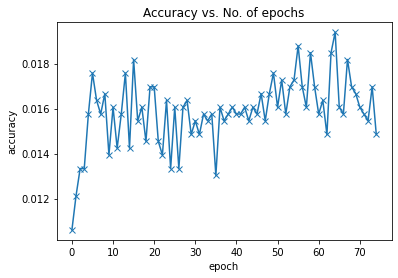

In [29]:
plot_accuracies(history)

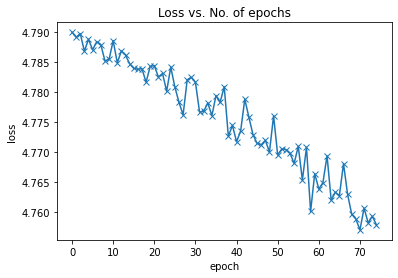

In [30]:
plot_losses(history)

In [31]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [40]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  # Retrieve the class label
  return classes[preds[0].item()]

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1,2,0))
print("Label:", classes[label], ', Predicted:', predict_image(img,model))

In [42]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

TypeError: ignored

In [ ]:
jovian.log_metrics(test_loss = result['test_loss'], test_acc = result['test_acc'])

In [ ]:
torch.save(model.state_dict(), 'stanforddogs_feedfwd.pth')
model2 = to_device(stanforddogs_feedfwd(), device)

In [ ]:
model2.load_state_dict(torch.load('stanforddogs_feedfwd.pth'))

In [ ]:
evaluate(model2, test_loader)

In [ ]:
#import torch
#import matplotlib.pyplot as plt
#%matplotlib inline

#def denormalize(images, means, stds):
#    if len(images.shape) == 3:
#        images = images.unsqueeze(0)
#    means = torch.tensor(means).reshape(1, 3, 1, 1)
#    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#    return images * stds + means

#def show_image(img_tensor, label):
#    print('Label:', dataset.classes[label], '(' + str(label) + ')')
#    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
#    plt.imshow(img_tensor)

In [ ]:
#show_image(*dataset[2])

In [ ]:
jovian.commit(project='zerogans-project-stanforddogsdataset-feedfwdnn')